In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 48kB/s 


In [3]:
!pip install tf-nightly 

     |████████████████████████████████| 324.1MB 48kB/s 
     |████████████████████████████████| 8.8MB 51.3MB/s 
     |████████████████████████████████| 460kB 58.5MB/s 


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_data_gen = ImageDataGenerator(rescale=1.0/255.0,
                                rotation_range=20,
                                fill_mode='nearest',
                                vertical_flip=True,
                                horizontal_flip = True
                               )
train_data = train_data_gen.flow_from_directory('/content/drive/My Drive/Project/chest_xray/train',
                                                target_size = (300,300),
                                                class_mode = 'categorical'
                                                )

Found 5208 images belonging to 3 classes.


In [7]:
val_data_gen = ImageDataGenerator(rescale=1.0/255.0)
test_data = val_data_gen.flow_from_directory('/content/drive/My Drive/Project/chest_xray/test',
                                             target_size = (300,300),
                                             class_mode = 'categorical'
                                             )

Found 624 images belonging to 3 classes.


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, Conv2D, MaxPool2D, BatchNormalization,Dense
from tensorflow.keras import Model,layers
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-08-05 13:18:28--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  93.9MB/s    in 0.9s    

2020-08-05 13:18:29 (93.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 17, 17, 768)


In [10]:
from tensorflow.keras.optimizers import RMSprop
x = Conv2D(256,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(last_output)
x = BatchNormalization()(x)
x = Conv2D(1,(1,1),activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = layers.Flatten()(x) 
x = Dense(256,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.4)(x)
x = Dense(128,activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.35)(x)
x = Dense(64,activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(3,activation = 'softmax')(x)
model = Model(pre_trained_model.input,x)
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [14]:
epochs_to_wait_for_improve = 30
n_epochs = 60
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint('CATEGORICAL'+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(train_data,validation_data=test_data,
            epochs=n_epochs, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/60
163/163 [==============================] - ETA: 0s - loss: 1.5346 - accuracy: 0.4362 
Epoch 00001: val_loss improved from inf to 1.31049, saving model to CATEGORICAL.h5
163/163 [==============================] - 1922s 12s/step - loss: 1.5336 - accuracy: 0.4367 - val_loss: 1.3105 - val_accuracy: 0.6122
Epoch 2/60
163/163 [==============================] - ETA: 0s - loss: 1.1329 - accuracy: 0.6574
Epoch 00002: val_loss improved from 1.31049 to 1.07150, saving model to CATEGORICAL.h5
163/163 [==============================] - 160s 982ms/step - loss: 1.1327 - accuracy: 0.6575 - val_loss: 1.0715 - val_accuracy: 0.6939
Epoch 3/60
163/163 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.7053
Epoch 00003: val_loss did not improve from 1.07150
163/163 [==============================] - 159s 974ms/step - loss: 1.0169 - accuracy: 0.7054 - val_loss: 1.3018 - val_accuracy: 0.5994
Epoch 4/60
163/163 [==============================] - ETA: 0s - loss: 0.9396 - accurac

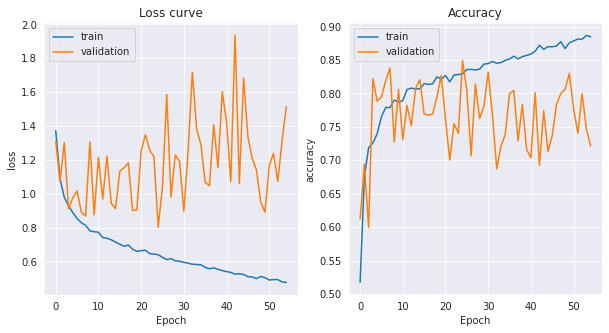

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("darkgrid")
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

#get the loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

#get the entries
xvalues = np.arange(len(train_acc))

#visualise
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues,  train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()